## Image processing of CT scans
### Xiao Luo
### importing libarary

In [2]:
import os
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import ndimage

from CTprocessinglib import read_pile  # read pile file and has option of filter data

from CTprocessinglib import print_stats # print the statistics of a scan slice

from CTprocessinglib import remove_outlier_std, remove_outlier_percentile # remove outlier data

from CTprocessinglib import reindex_scan # flatten scan data

from CTprocessinglib import pick_circle # get circle centers for scans

from CTprocessinglib import create_circular_mask # a disc-shape mask

from CTprocessinglib import create_square_mask # a square-shape mask 

from CTprocessinglib import crop_scan # crop out the scan based on the circular and square mask

### the functions are defined here

In [3]:
path=os.path.expanduser('~\\Box Sync\\CT result\\CT_workflow')  
# get the relative path to the user directory
os.chdir(path) # set the working directory


two baseline scans are processed and saved to npy file

In [4]:
# read the pile file: specify path, filename, and filter size
airBL = read_pile(path,'pile_LX_airBL_072019_01',4)
oilBL = read_pile(path,'pile_LX_oilBL_072019_01',4)

let plot some of the cross sections to visualize the scan, let n be the slice number. In python, n starts from 0

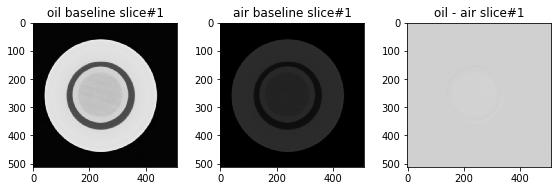

In [6]:
n = 1
nr, nc, nz = airBL.shape
o1 = oilBL[:,:,n]
a1 = airBL[:,:,n]

plt.subplot(131)
imgplot = plt.imshow(o1,cmap='gray')
plt.title('oil baseline slice#'+str(n))

plt.subplot(132)
imgplot = plt.imshow(a1,cmap='gray')
plt.title('air baseline slice#'+str(n))

plt.subplot(133)
imgplot = plt.imshow(o1-a1,cmap='gray')
plt.title('oil - air slice#'+str(n))

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.2, top=1.0, wspace=0.3, hspace=0.2)
plt.draw()

Although the grey scale image looks fine, but it can fool you if you look at the statistics. A easy way to obtain the statistics is to convert the image to dataframe array.

In [7]:
print_stats(airBL,n=0)
print_stats(oilBL,n=0)

                   0
count  262144.000000
mean      366.659580
std      1489.929729
min     -1058.000000
25%     -1000.000000
50%      -978.000000
75%      2194.000000
max      2389.000000
                   0
count  262144.000000
mean      383.889980
std      1502.038162
min     -1059.000000
25%     -1000.000000
50%      -975.000000
75%      2195.000000
max      2388.000000


### outlier filters (1)

#### $\sigma$ method

Now, let us remove the outliers, and print the statistics

                   0
count  262144.000000
mean      366.659580
std      1489.929729
min     -1058.000000
25%     -1000.000000
50%      -978.000000
75%      2194.000000
max      2389.000000
                   0
count  262144.000000
mean      383.889980
std      1502.038162
min     -1059.000000
25%     -1000.000000
50%      -975.000000
75%      2195.000000
max      2388.000000


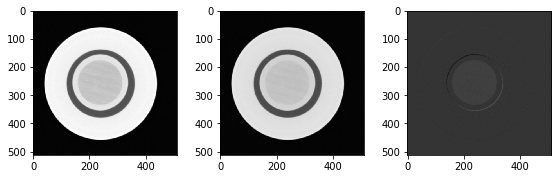

In [10]:
airBL2=remove_outlier_std(airBL,std_mplier=2,t_set=-0)
oilBL2=remove_outlier_std(oilBL,std_mplier=2,t_set=-0)

print_stats(airBL2,n=0)
print_stats(oilBL2,n=0)

plt.subplot(131)
imgplot = plt.imshow(airBL2[:,:,n],cmap='gray')
plt.subplot(132)

imgplot = plt.imshow(oilBL2[:,:,n],cmap='gray')
plt.subplot(133)

imgplot = plt.imshow(oilBL2[:,:,n]-airBL2[:,:,n],cmap='gray')
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.2, top=1.0, wspace=0.3, hspace=0.2)
plt.draw()

### outlier filters (2)

#### percentile method

                   0
count  262144.000000
mean     -118.730965
std      1311.979418
min     -1008.000000
25%     -1000.000000
50%      -995.000000
75%      1561.000000
max      2235.000000
                   0
count  262144.000000
mean      -96.543720
std      1334.589533
min     -1008.000000
25%     -1000.000000
50%      -995.000000
75%      1760.000000
max      2236.000000


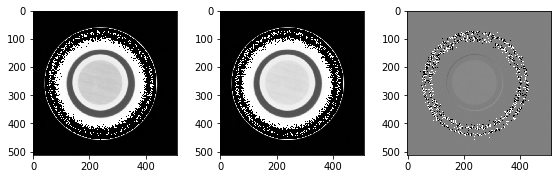

In [11]:
airBL3=remove_outlier_percentile(airBL,10,85,t_set=-1000)
oilBL3=remove_outlier_percentile(oilBL,10,85,t_set=-1000)

print_stats(airBL3,n=0)
print_stats(oilBL3,n=0)

plt.subplot(131)
imgplot = plt.imshow(airBL3[:,:,n],cmap='gray')
plt.subplot(132)

imgplot = plt.imshow(oilBL3[:,:,n],cmap='gray')
plt.subplot(133)

dn = oilBL3[:,:,n]-airBL3[:,:,n]
imgplot = plt.imshow(dn,cmap='gray')
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.2, top=1.0, wspace=0.3, hspace=0.2)
plt.draw()

                   0
count  262144.000000
mean       22.975937
std       725.883803
min     -3235.000000
25%        -5.000000
50%         0.000000
75%        10.000000
max      3236.000000


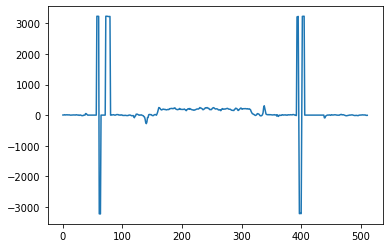

In [9]:
dif3 = oilBL3-airBL3

n = 2
temp3 = dif3[:,:,n]
arr3 = temp3.reshape(nr*nc)

row = 250
plt.plot(temp3[row,:])

print_stats(oilBL3-airBL3,n)

optional, sometimes, it is good to flatten the 3D image on a 2D matrix, such that the first two column are the x and y, the third column and so forth are the greyscale. It is easy to compare statistics this way. 

In [10]:
flat_scan = reindex_scan(dif3)
print(flat_scan[['x','y','slice20']].head(n=15))

      x     y  slice20
0   0.0   0.0      0.0
1   0.0   1.0     -7.0
2   0.0   2.0     -8.0
3   0.0   3.0      0.0
4   0.0   4.0      0.0
5   0.0   5.0      2.0
6   0.0   6.0      2.0
7   0.0   7.0      0.0
8   0.0   8.0     -3.0
9   0.0   9.0      5.0
10  0.0  10.0      0.0
11  0.0  11.0    -16.0
12  0.0  12.0     -3.0
13  0.0  13.0     -3.0
14  0.0  14.0     12.0


In [11]:
# Do not run! this will freeze computer

# from sklearn.preprocessing import StandardScaler
# from sklearn.cluster import DBSCAN

# s = StandardScaler()
# transformer = s.fit(flat_scan[['x','y','slice1']])
# df_mm = transformer.transform(flat_scan[['x','y','slice1']])      # transform the data based on the fit

# clus_m = DBSCAN(eps=1.5, min_samples=1000)

# df_clus = clus_m.fit(df_mm)

# imgplot = plt.imshow(df_clus.labels_.reshape(nr,nc),cmap='plasma')
# plt.show()

making a circular mask, the mask is a bolean matrix that contains the indices for the elemnts of interest. 

3756.46350214583


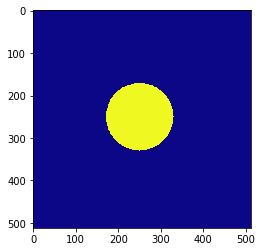

In [12]:
mask_temp = create_circular_mask(nr, nc, center=[250,250], radius=79)

print(np.var(dn[mask_temp]))
imgplot = plt.imshow(mask_temp,cmap='plasma')
plt.show()

we also need to create a square mask that it contained the circular mask

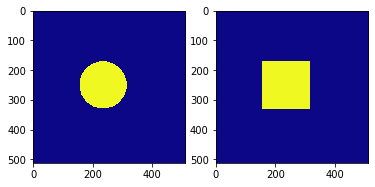

In [13]:

mask_temp = create_circular_mask(nr, nc, center=[234,250], radius=79)
plt.subplot(121)
imgplot = plt.imshow(mask_temp,cmap='plasma')


plt.subplot(122)
mask_temp2 = create_square_mask(nr, nc, center=[234,250], radius=79)
imgplot = plt.imshow(mask_temp2,cmap='plasma')


I can generate various circular mask and see which one of mask center cuts the best circle. 

237
251


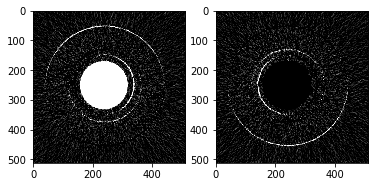

In [15]:
dif2 = oilBL2-airBL2

n=30  # for any number of slices

xi=240;yi=253
dx=1;nx=10
dy=1;ny=10
r=79;nr=512;nc=512
xc, yc = pick_circle(xi,yi,dx,dy,nx,ny,r,dif2[:,:,n])
print(xc)
print(yc)

plt.subplot(121)
temp = dif2[:,:,n]
imgplot = plt.imshow(temp,vmin=0,vmax=100,cmap='gray')
plt.subplot(122)
mask_temp = create_circular_mask(nr, nc, center=[xc,yc], radius=r)
d = np.where(mask_temp,1,0)
#print(d.shape)
imgplot = plt.imshow(temp*d-temp,vmin=0,vmax=100,cmap='gray')


#### cut circle without human labour
the result is pretty good, now, let pick the circles for all slices. Here, I cut the circle for all slices, the result is then saved to an numpy array file.

In [16]:
circle_centers = np.zeros((nz,2))
x_guess = 238
y_guess = 253

dx=1;nx=4
dy=1;ny=4
r=79;

for i in range(nz):
    x_guess, y_guess = pick_circle(x_guess,y_guess,dx,dy,nx,ny,r,dif2[:,:,i])
    circle_centers[i,:] = [x_guess,y_guess]

circle_centers = circle_centers.astype(int)
    
print(circle_centers)
np.save('circle_centers',circle_centers)     

[[237 253]
 [238 254]
 [238 254]
 [237 253]
 [237 254]
 [236 254]
 [235 254]
 [235 255]
 [235 254]
 [235 254]
 [235 253]
 [235 253]
 [235 253]
 [236 253]
 [236 253]
 [236 253]
 [236 253]
 [236 253]
 [236 253]
 [236 253]
 [236 252]
 [236 252]
 [236 252]
 [236 252]
 [236 252]
 [237 252]
 [237 252]
 [237 251]
 [237 251]
 [237 251]
 [237 251]
 [237 251]
 [237 251]
 [238 251]
 [238 251]]


Now, I obtained the circle centers from circular masks, but I cannot image matrix through a circular shaped mask. Hence, I have to extract the circle centers and create a square mask that contains the circle of interest. 

#### generate square and circular mask matrix

In [17]:
dr = 0
ms = creat_mask_matrix(nr, nc, nz, circle_centers, r+dr, 'square')
mc = creat_mask_matrix(nr, nc, nz, circle_centers, r, 'circle')
print(ms.shape)
print(mc.shape)

(512, 512, 35)
(512, 512, 35)


### calculation of local porosity

$\Omega^{bulk}=(1-\phi)\Omega^{rock}+\phi S^I \Omega^I + \phi (1-S^I) \Omega^{II}$

#### only phase I is present:
$\Omega^{b,I}=(1-\phi)\Omega^{rock}+\phi  \Omega^I $

#### only phase II is present:
$\Omega^{b,II}=(1-\phi)\Omega^{rock}+\phi  \Omega^{II} $


#### porosity:
$\Omega^{b,I}-\Omega^{b,II}=\phi(\Omega^I-\Omega^{II})$

$\phi=\frac{\Omega^{b,I}-\Omega^{b,II}}{\Omega^I-\Omega^{II}}$

in this example, $\Omega^{b,I}$ is the airBL and $\Omega^{b,II}$ is the oilBL. $\Omega^I-\Omega^{II}$ is based on the fluid properties. If the rock porosity and density are relatively uniform, $\Omega^I-\Omega^{II}$ should also be uniform. 

#### it is also important to set the porosity values that are outside circular mask to be NaN because it is easy to neglect NaN value when we need to calculate averages or plot projections


Step 1, I calculate porosity values using the full matrix of air and oil baselines

In [18]:
# CT attenuation of the pure fluids
omega_I = -1000
omega_II = -325
porosity_full = (airBL - oilBL) / (omega_I - omega_II)
print(porosity_full.shape)
#print(np.min(porosity_mat))

(512, 512, 35)


Step 2, assign all value that are not in circular mask to be NaN

(512, 512, 35)


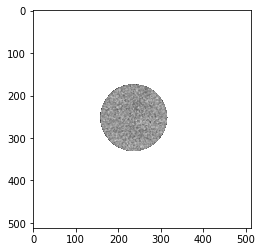

In [19]:
porosity_full[~mc] = float('nan')
imgplot = plt.imshow(porosity_full[:,:,24],vmin=0,vmax=0.5,cmap='gray')
print(porosity_full.shape)

Step 3, extract the useful porosity through the square mask

(159, 159, 35)
0.04296296296296296


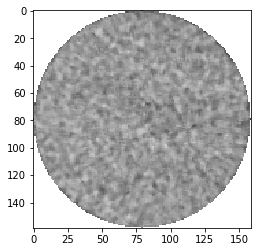

In [20]:
por_m = np.zeros((2*r+1,2*r+1,nz))

for i in range(nz):
    sqm = ms[:,:,i]
    temp = porosity_full[:,:,i]        
    por_m[:,:,i] = np.reshape(temp[sqm],((2*r+1,2*r+1)))

imgplot = plt.imshow(por_m[:,:,20],vmin=0,vmax=0.5,cmap='gray')

print(por_m.shape)
print(np.nanmin(por_m[:,:,:]))

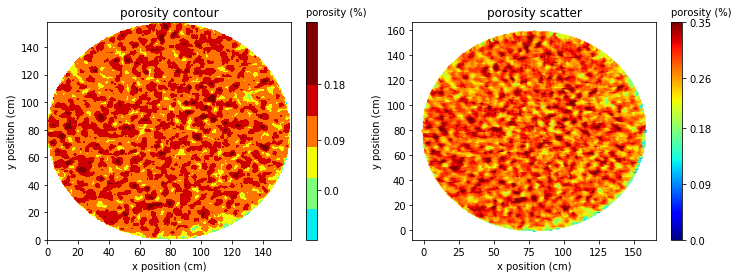

In [21]:
n=34
x = np.arange(2*(r+dr)+1)#/(2*r)*3.81
y = np.arange(2*(r+dr)+1)#/(2*r)*3.81
X, Y = np.meshgrid(x, y)

#zmin = round(np.nanmin(por_m)); zmax = round(np.nanmax(por_m))
zmin = 0; zmax = 0.35
#zmin=10;zmax=25;nl=4;
c_ticks = np.linspace(zmin, zmax, 5) # pre-specify colorbar ticks
c_ticks = np.round(c_ticks,2)
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,4))   
#fig, ax1 = plt.subplots(1,1,figsize=(6,5))  
cf1 = ax1.contourf(X, Y, por_m[:,:,n], 6, vmin=zmin, vmax=zmax, cmap='jet') # contour plot with 5 levels
cb1 = fig.colorbar(cf1, ax=ax1)
cb1.set_ticks(c_ticks)
cb1.set_ticklabels(c_ticks)
cb1.set_label('porosity (%)', labelpad=-10, y=1.07, rotation=0)
ax1.set_xlabel('x position (cm)');ax1.set_ylabel('y position (cm)');ax1.set_title('porosity contour'); # specify labels and titles#plt.colorbar()

cf2 = ax2.scatter(X,Y,c=por_m[:,:,n],vmin=zmin,vmax=zmax,s=10,cmap='jet')   #the z axis (color) is the porosity
cb2 = fig.colorbar(cf2, ax=ax2)
cb2.set_ticks(c_ticks)
cb2.set_ticklabels(c_ticks)
cb2.set_label('porosity (%)', labelpad=-10, y=1.07, rotation=0)
ax2.set_xlabel('x position (cm)');ax2.set_ylabel('y position (cm)');ax2.set_title('porosity scatter');


The routine shown above is include in a subroutine to crop the CT scans. 

C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  


(159, 35)


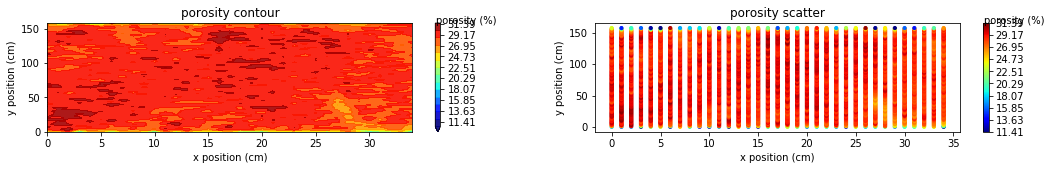

In [23]:
porosity = crop_scan(porosity_full,mc,ms)
porosity[porosity<0]=0

p_slice = np.nanmean(porosity, axis=1)

[n1,n2]=p_slice.shape

x = np.arange(n1)
y = np.arange(n2)

X, Y = np.meshgrid(y, x)
print(Y.shape)

from matplotlib.ticker import MaxNLocator
zmin = np.min(p_slice)*100; zmax = np.max(p_slice)*100

levels = MaxNLocator(nbins=15).tick_values(zmin, zmax)

#zmin = round(np.nanmin(por_m)); zmax = round(np.nanmax(por_m))

#zmin=10;zmax=25;nl=4;
c_ticks = np.linspace(zmin, zmax, 10) # pre-specify colorbar ticks
c_ticks = np.round(c_ticks,2)
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(18,2))   
#fig, ax1 = plt.subplots(1,1,figsize=(6,5))  
cf1 = ax1.contourf(X, Y, p_slice*100, levels=levels, vmin=zmin,vmax=zmax, cmap='jet',alpha=0.9,corner_mask=True,extend='min') # contour plot with 5 levels
cb1 = fig.colorbar(cf1, ax=ax1)
cb1.set_ticks(c_ticks)
cb1.set_ticklabels(c_ticks)
cb1.set_label('porosity (%)', labelpad=-10, y=1.07, rotation=0)
ax1.set_xlabel('x position (cm)');ax1.set_ylabel('y position (cm)');ax1.set_title('porosity contour'); # specify labels and titles#plt.colorbar()

cf2 = ax2.scatter(X,Y,c=p_slice*100, vmin=zmin,vmax=zmax,s=10,cmap='jet')   #the z axis (color) is the porosity
cb2 = fig.colorbar(cf2, ax=ax2)
cb2.set_ticks(c_ticks)
cb2.set_ticklabels(c_ticks)
cb2.set_label('porosity (%)', labelpad=-10, y=1.07, rotation=0)
ax2.set_xlabel('x position (cm)');ax2.set_ylabel('y position (cm)');ax2.set_title('porosity scatter');



From now on, I can simply use crop_scan function to produce scan matrix can be used for local saturation calculations. Going back to the equations:

$\Omega^{bulk}=(1-\phi)\Omega^{rock}+\phi S^I \Omega^I + \phi (1-S^I) \Omega^{II}$

#### only phase I is present:
$\Omega^{b,I}=(1-\phi)\Omega^{rock}+\phi  \Omega^I $

#### subtract the bottom equation from the top equation

$\Omega^{bulk}-\Omega^{b,I} = \phi S^I \Omega^I + \phi (1-S^I) \Omega^{II} - \phi  \Omega^I$

$\Omega^{bulk}-\Omega^{b,I} = \phi S^I (\Omega^I - \Omega^{II}) - \phi  (\Omega^I-\Omega^{II})$

$S^I = 1+\frac{\Omega^{bulk}-\Omega^{b,I}}{\phi  (\Omega^I-\Omega^{II})}$

read pile files

In [56]:
k=3 # median filter size
flow1 = read_pile(path,'pile_LX_oilFb_072119_02',k)
flow2 = read_pile(path,'pile_LX_oilFb_072119_04',k)
flow3 = read_pile(path,'pile_LX_oilFb_072119_06',k)
flow4 = read_pile(path,'pile_LX_oilFb_072119_08',k)
flow5 = read_pile(path,'pile_LX_oilFb_072119_10',k)

crop scans

In [57]:
f1 = crop_scan(flow1.astype(float),mc,ms)
f2 = crop_scan(flow2.astype(float),mc,ms)
f3 = crop_scan(flow3.astype(float),mc,ms)
f4 = crop_scan(flow4.astype(float),mc,ms)
f5 = crop_scan(flow5.astype(float),mc,ms)
bo = crop_scan(oilBL2.astype(float),mc,ms)

omega_I = -953
omega_II = -325

so1 = 1-np.divide((f1-bo)/(omega_I - omega_II), porosity)
so2 = 1-np.divide((f2-bo)/(omega_I - omega_II), porosity)
so3 = 1-np.divide((f3-bo)/(omega_I - omega_II), porosity)
so4 = 1-np.divide((f4-bo)/(omega_I - omega_II), porosity)
so5 = 1-np.divide((f5-bo)/(omega_I - omega_II), porosity)

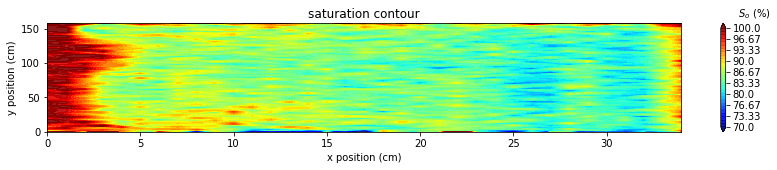

In [58]:
Z = so2
#Z[Z<0]=0
#Z[Z>1.05]=1.00

p_slice = np.nanmean(Z, axis=1)

[n1,n2]=p_slice.shape

x = np.arange(n1)
y = np.arange(n2)

X, Y = np.meshgrid(y, x)

#from matplotlib.ticker import MaxNLocator
#zmin = np.min(p_slice)*100; zmax = np.max(p_slice)*100
zmin = 70; zmax = 100
#levels = MaxNLocator(nbins=15).tick_values(zmin, zmax)


#zmin=10;zmax=25;nl=4;
c_ticks = np.linspace(zmin, zmax, 10) # pre-specify colorbar ticks
c_ticks = np.round(c_ticks,2)
core_width = 2
aspect_ratio = 7.1
#fig, (ax1,ax2) = plt.subplots(1,2,figsize=(18,2))   
fig, ax1 = plt.subplots(1,1,figsize=(core_width*aspect_ratio,core_width ))  
cf1 = ax1.contourf(X, Y, p_slice*100, np.linspace(zmin, zmax, 30), cmap='jet',alpha=0.9,corner_mask=True,extend='both') # contour plot with 5 levels
cb1 = fig.colorbar(cf1, ax=ax1)
cb1.set_ticks(c_ticks)
cb1.set_ticklabels(c_ticks)
cb1.set_label('$S_o$ (%)', labelpad=-7, y=1.15, rotation=0)
ax1.set_xlabel('x position (cm)');ax1.set_ylabel('y position (cm)');ax1.set_title('saturation contour'); # specify labels and titles#plt.colorbar()


